# Analyzing data to obtain insights

This notebook is an adaptation of the [original by *Aurélien Gerón*](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb), from his book: [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition. Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

## Previous steps

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

housing = pd.read_csv("./data/housing.csv") # Load the dataset

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5]) # Add income categories for stratification

## Geographic data visualization

Let's create a scatter plot of all districts to visualize the geographic data.

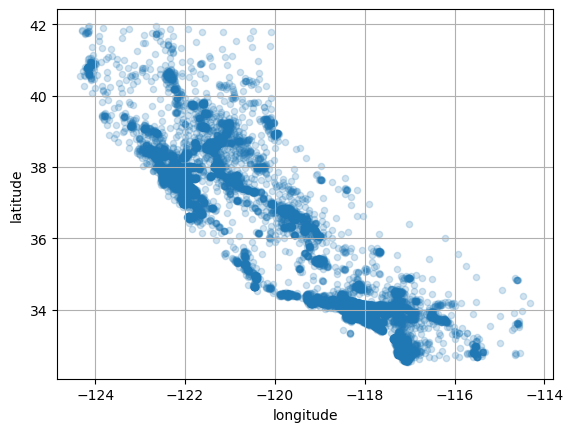

In [2]:
import matplotlib.pyplot as plt

_ = housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)

Visualization of each record on its geographic position (latitude and longitude), with a color scale representing the median house value and circle size representing the population.

In [ ]:
_ = housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, # circle radius represents district population
             label="population", # label for the legend
             c="median_house_value", # point color represents median house value
             cmap="jet", # use the "jet" color palette
             colorbar=True,
             legend=True)

Positioning the same on a map.

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude",
             s=housing["population"] / 100, # circle size proportional to population
             label="Population", 
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True)

california_img = plt.imread("./img/california.png")
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()

Visualizing the 'ocean_proximity' values with colors geographically (will be useful when we preprocess this categorical variable).

In [ ]:
import seaborn as sns
import PIL
import matplotlib.pyplot as plt

sns.scatterplot(x="longitude", y="latitude", hue="ocean_proximity", data=housing)
axis = -124.55, -113.95, 32.45, 42.05 # longitude and latitude limits of the image
plt.imshow(PIL.Image.open("./img/california.png", mode='r'), extent=axis)
plt.show()

## Looking for correlations

The `corr()` method of Pandas calculates the **Pearson correlation coefficient** (PCC) between each pair of attributes. This coefficient ranges from -1 to 1 indicating the degree of linear correlation between two variables. When it's close to 1, it means there's a strong positive correlation (variables tend to increase together). When the coefficient is close to -1, it means there's a strong negative correlation (one variable decreases when the other increases). Finally, coefficients close to 0 mean there's no linear correlation.
We use the argument `numeric_only=True` to calculate correlation only between numeric variables, ignoring the categorical variable 'ocean_proximity'.

In [6]:
corr_matrix = housing.corr(numeric_only=True) 

Having this correlation matrix, let's see in an ordered way which variables correlate most with the **target variable**, 'median_house_value'. The `sort_values()` method of Pandas allows us to sort the values of a series; additionally, we can use the `key` parameter to pass a function that will be applied to each value before sorting. In this case, we want to sort by absolute value, since a strong negative correlation is just as interesting as a positive one.

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False, key=np.abs) # sort values by correlation with respect to absolute value

We observe that the variable that correlates most with 'median_house_value' is 'median_income', with a coefficient of 0.69. It's therefore the ***feature*** that most determines housing prices.

We can also see the correlations with a scatter plot of the variables most correlated with 'median_house_value', using the `scatter_matrix` function from Pandas. On the diagonal we see that it places their histograms (as seen at the beginning) by default, since comparing a variable with itself would only give a straight line without useful information.

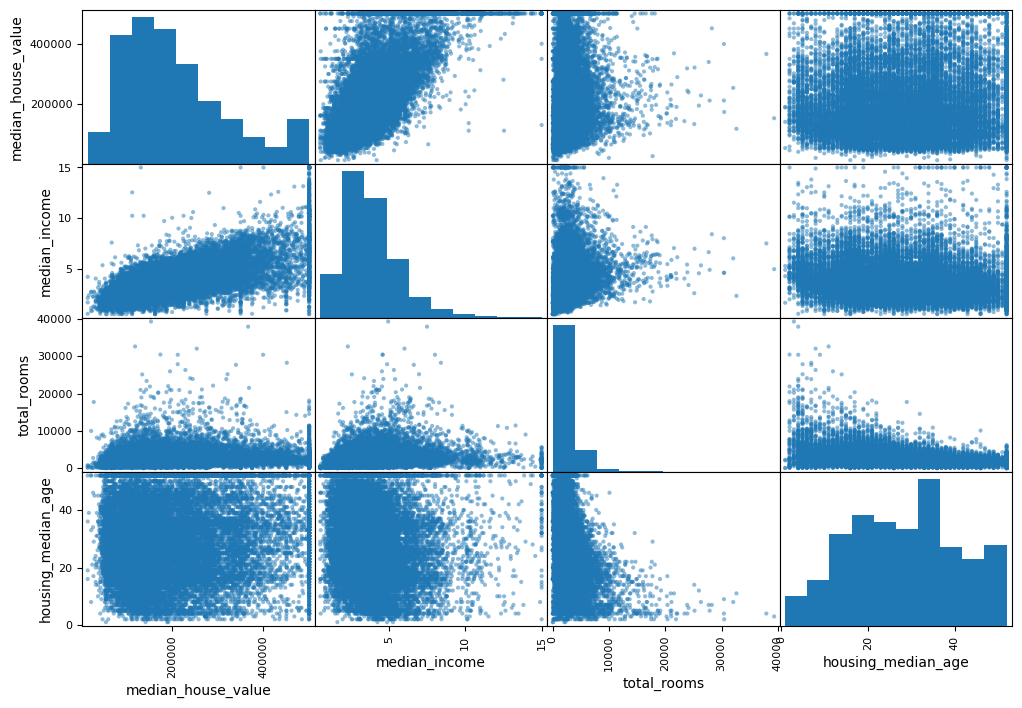

In [8]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

Again we see how the clearest correlation is with 'median_income', the more it increases, the more the median house value increases. We can also see that the limit of 500,000 USD we mentioned before is clearly visible in the graph, as a horizontal line at the top of the y axis.

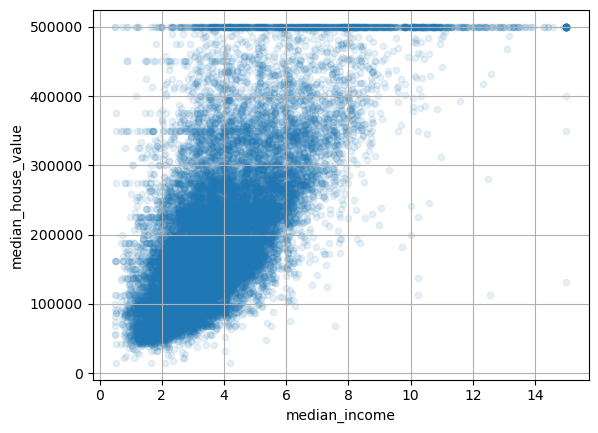

In [9]:
_ = housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)

## Combining attributes (*feature engineering*)

<!-- TODO: this is part of preprocessing, move to later notebook (although in the book it's in that subsection) -->

It will often make sense to try to combine certain variables to obtain new, more useful variables. For example, the total number of rooms is not very useful if we don't know how many households there are. What we really want is the number of rooms per household. Similarly, the total number of bedrooms alone is not very useful: we probably want to compare it with the number of rooms. And population per household also seems like an interesting attribute combination to look at. Let's create these new variables.

Therefore, we add columns with these new variables to the dataframe and see their correlations with 'median_house_value'.

In [ ]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"] # number of rooms per house
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"] # ratio of bedrooms to total rooms
housing["people_per_house"] = housing["population"] / housing["households"] # number of people per house

In [11]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False, key=np.abs)

median_house_value    1.000000
median_income         0.688075
bedrooms_ratio       -0.255880
rooms_per_house       0.151948
latitude             -0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
longitude            -0.045967
population           -0.024650
people_per_house     -0.023737
Name: median_house_value, dtype: float64

We've obtained a new attribute "bedrooms_ratio" that has a much higher correlation with "median_house_value" than the total number of rooms or bedrooms. Apparently, houses with a lower bedroom/room ratio tend to be more expensive. Additionally, the number of rooms per household also has a higher correlation than the total number of rooms or bedrooms.